In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
from scipy import ndimage


from readImages import *
from imageModifiers import *
from readDataFiles import *
from projEdgeBreaks import *
from gaussBreaks import *
from saveImages import *
from plottingFuncs import *
from gap_metric_breaks import *

In [2]:
mpl.rcParams["figure.figsize"] = (15, 15)
# %matplotlib inline

subjFile = "data/anti-slavery-manuscripts-subjects.csv"
subj = pd.read_csv(subjFile)

# get metadata in dictionary format
subj["meta_json"] = [json.loads(q) for q in subj["metadata"]]

# get image url
subj["url"] = [json.loads(q).get("0") for q in subj["locations"]]

# get beta images
subj_beta = subj.loc[subj["subject_set_id"] == 16451]
subj_beta = subj_beta.drop_duplicates(["subject_id", "locations"])
len(subj_beta)

11

# Line segmentation based on sliding projection profile
http://ieeexplore.ieee.org.ezp1.lib.umn.edu/document/953799/?reload=true  
https://www.researchgate.net/profile/Itshak_Dinstein/publication/220860268_Line_Segmentation_for_Degraded_Handwritten_Historical_Documents/links/5527cc180cf2779ab78ab9d6.pdf

# Line segmentation based on ACLM
http://www.cedar.buffalo.edu/~zshi/Papers/ICDAR_05_zshi_lineSeg.pdf

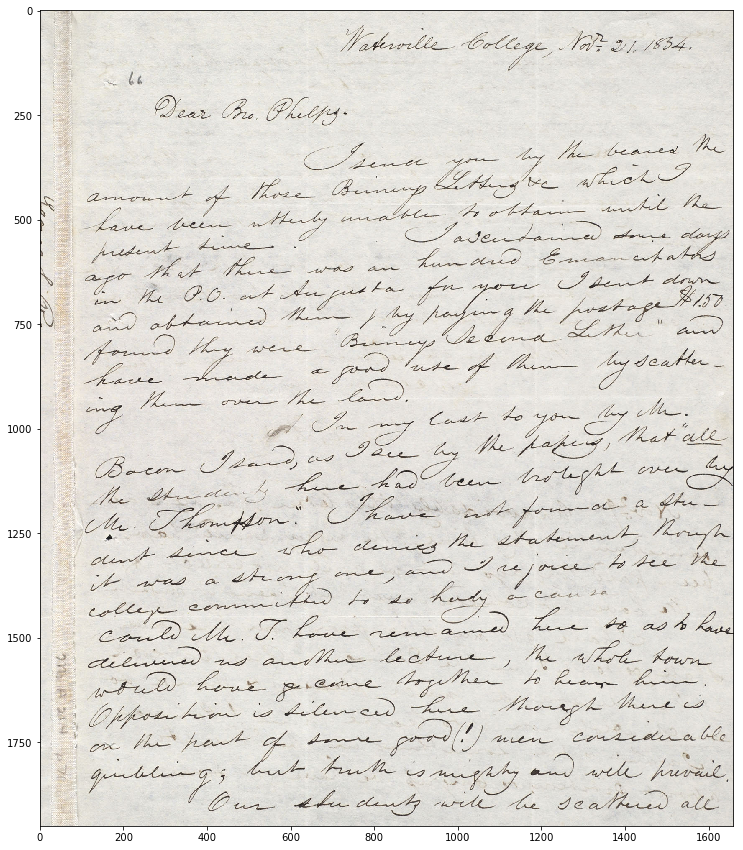

In [3]:
i = 4 # 4 is slightly tilted, 5 is fairly tilted
let_orig, grey_orig = readImg(subj_beta["url"].iloc[i])
grey, let, offset = removeEdges(grey_orig, let_orig, 10.0)

plquick(let, "rainbow")

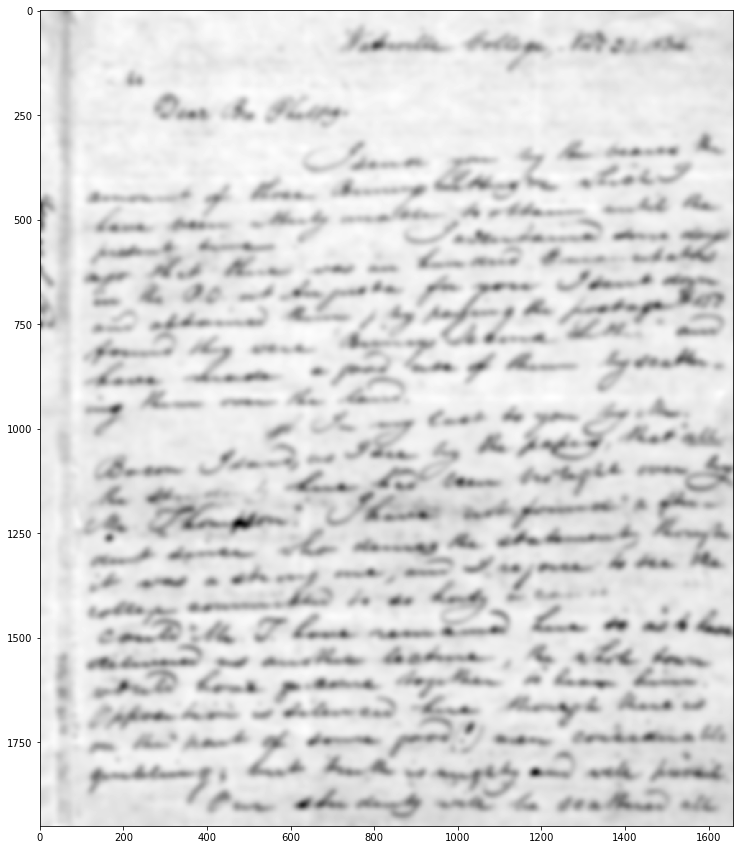

In [4]:
greySm = smoothImg(grey, 7.0, plotIt=True)

In [5]:
# Binarize Image
greyBi, _ = binarizeImg(greySm, threshFn=skimfilt.threshold_otsu, greater=False)

# get labeled CCs
labels, nr_obj = ndimage.label(greyBi, structure=[[1,1,1],[1,1,1],[1,1,1]])

# Remove all objects that are just absolutely tiny
sizeThresh = 10
labs = np.unique(labels)
for lab in labs:
    size = np.sum(labels == lab)
    if size < sizeThresh:
        labels[labels == lab] = 0

# Relabel CCs after removal of smalls
greyBi = (labels > 0).astype("int")
labels, nr_obj = ndimage.label(greyBi, structure=[[1,1,1],[1,1,1],[1,1,1]])

# get estimate letter width
osli = ndimage.find_objects(labels)
widths = [x[1].indices(10**10)[1] - x[1].indices(10**10)[0] for x in osli]
print(np.median(widths), np.mean(widths))
heights = [x[0].indices(10**10)[1] - x[0].indices(10**10)[0] for x in osli]
print(np.median(heights), np.mean(heights))

78.5 99.8333333333
40.0 46.7765151515


In [10]:
winsize = int(2*np.mean(heights))

In [11]:
grey_flipped = 1 - grey
grey_proj = []
ncol = grey_flipped.shape[1]
for i in range(0, ncol):
    val = project(grey_flipped[:,max(0,i-winsize):min(ncol-1, i+winsize)], "y")
    grey_proj.append(val)

grey_proj = np.array(grey_proj).T
print(grey_proj.shape, grey.shape)

(1951, 1659) (1951, 1659)


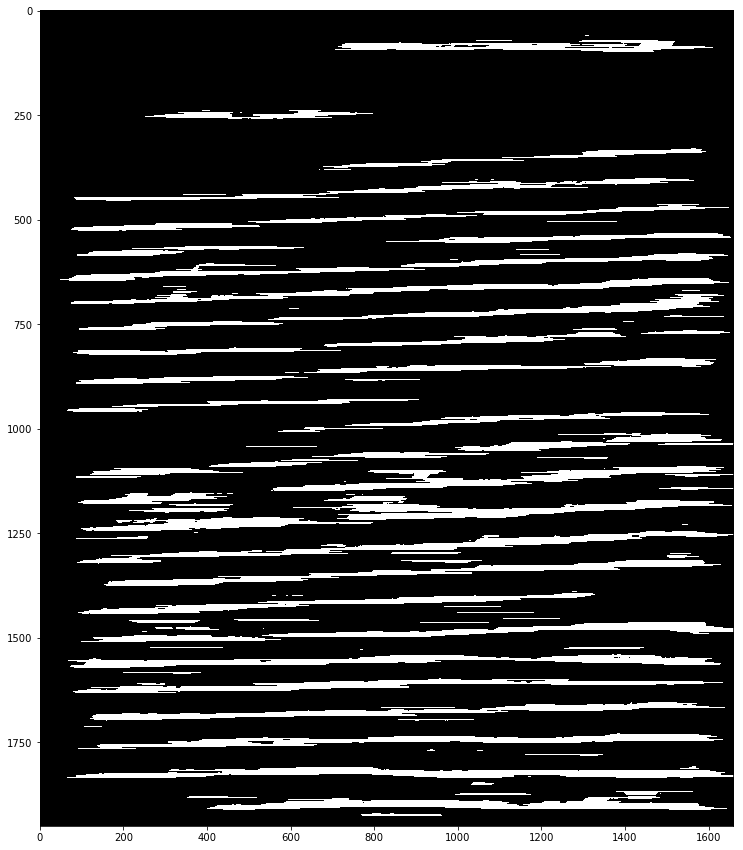

In [12]:
proj_bi, _ = binarizeImg(grey_proj, threshFn=skimfilt.threshold_otsu)
plquick(proj_bi, "gray")

# Line segmentation based on "shredding"
http://www.iapr-tc11.org/archive/icdar2009/papers/3725a626.pdf  
Variable names will generally be based on those in the paper

In [ ]:
# load libraries (if needed)


In [13]:
i = 4 # 4 is slightly tilted, 5 is fairly tilted
let_orig, grey_orig = readImg(subj_beta["url"].iloc[i])
grey, let, offset = removeEdges(grey_orig, let_orig, 10.0)

# plt.imshow(let)
# plt.show()

### 2.1 Stage 1: preprocessing

In [14]:
# Binarize Image
I, _ = binarizeImg(grey, threshFn=skimfilt.threshold_otsu, greater=False)

# get labeled CCs
LIN, nr_obj = ndimage.label(I, structure=[[1,1,1],[1,1,1],[1,1,1]])

In [15]:
# Remove all objects that are just absolutely tiny
sizeThresh = 10
labs = np.unique(LIN)
for lab in labs:
    size = np.sum(LIN == lab)
    if size < sizeThresh:
        LIN[LIN == lab] = 0

In [16]:
# Relabel CCs after removal of smalls
I = (LIN > 0).astype("int")
LIN, nr_obj = ndimage.label(I, structure=[[1,1,1],[1,1,1],[1,1,1]])

In [17]:
# get estimate letter height
osli = ndimage.find_objects(LIN)
heights = [x[0].indices(10**10)[1] - x[0].indices(10**10)[0] for x in osli]
LH = np.median(heights)
BW = np.floor(LH*8).astype("int")
BH = np.floor(LH*0.8).astype("int")

In [18]:
# get blurred image based on sum of nearby pixels
import time
st = time.time()
B = ndimage.convolve(I, np.ones((BH, BW)), mode="constant")
print(time.time()-st)

12.555849552154541


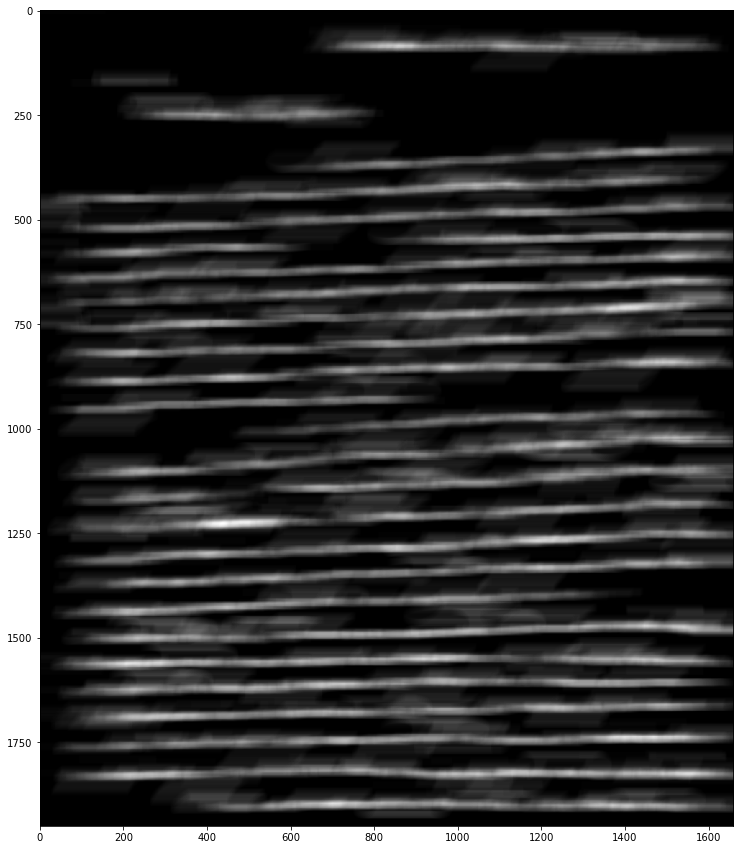

In [19]:
plquick(B, "gray")

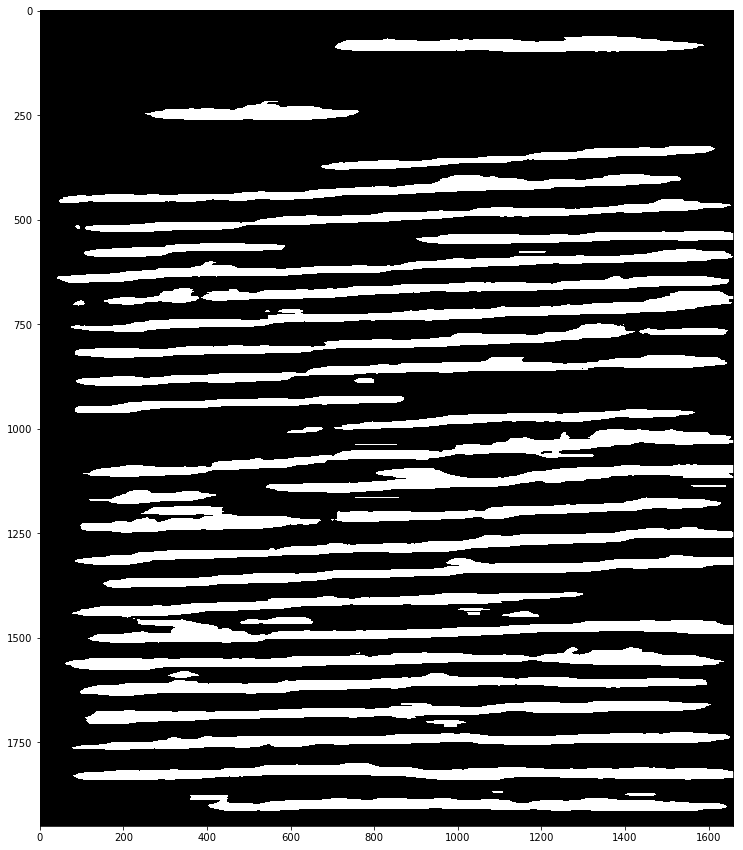

In [22]:
B3 = binarizeImg(B, threshFn=skimfilt.threshold_otsu)[0]
plquick(B3, 'gray')

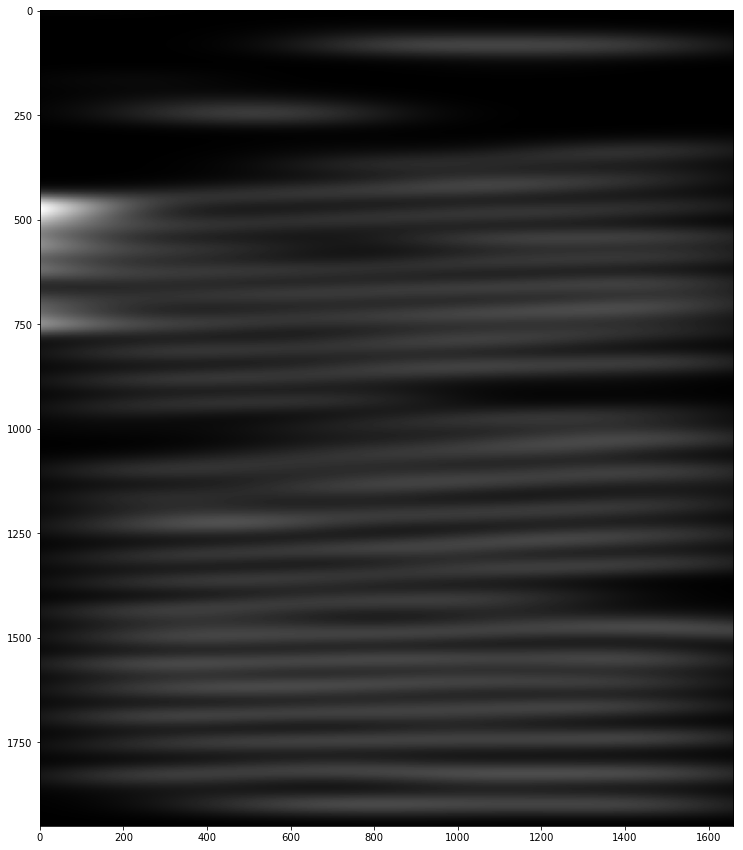

In [20]:
B2 = skimfilt.gaussian(I, (BH, BW))
plquick(B2, "gray")

### Stage 2: Image shredding

2.2.1 Tracing line areas

In [23]:
def Tr_np1(n, Tr_n, k=1, B=B):
    val1 = B[min(B.shape[0]-1, int(Tr_n+BH/2.0)), n]
    val2 = B[min(B.shape[0]-1, int(Tr_n-BH/2.0)), n]
    mod = 0
    if val1 > val2:
        mod = -1
    elif val1 < val2:
        mod = 1
    return Tr_n + mod

In [24]:
nk = B.shape[0]
Tr_list = []
for k in range(nk):
    tmp_list = []
    tmp_list.append(k)
    for n in range(1, B.shape[1]):
        tmp_list.append(Tr_np1(n, tmp_list[n-1], k, B))
    Tr_list.append(tmp_list)

In [25]:
Tr_arr = np.array(Tr_list)

LA = np.ones(B.shape)
for y in range(B.shape[0]):
    for x in range(B.shape[1]):
        if y in Tr_arr[:, x]:
            LA[y, x] = 0

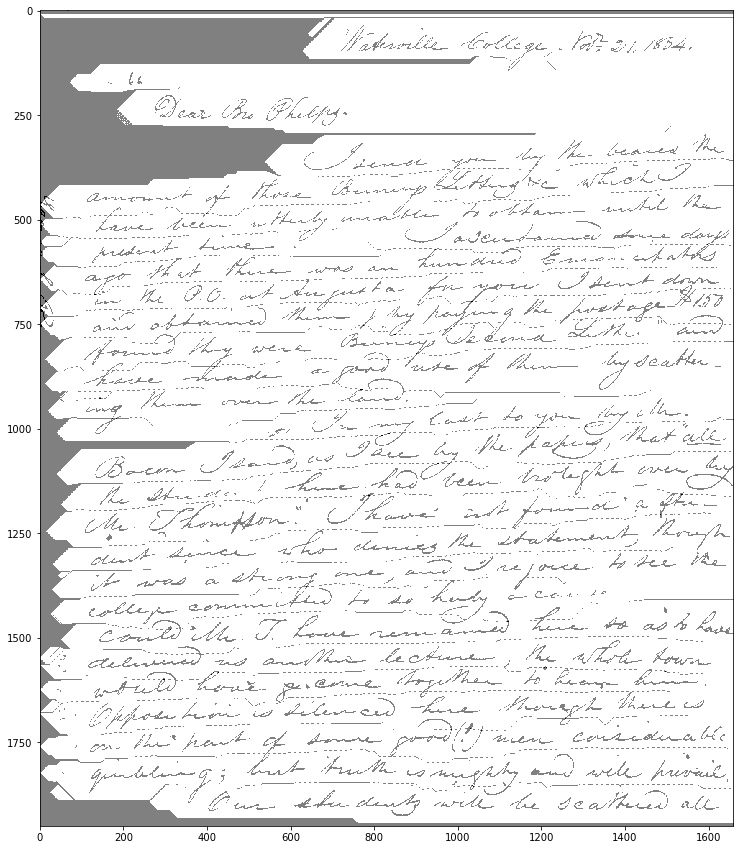

In [26]:
np.sum(np.ones(B.shape)) - np.sum(LA)
# plquick(LA, "gray")
plt.imshow(LA+(1-I), cmap="gray")
plt.show()

Using gaussian image

In [27]:
nk = B.shape[0]
Tr_list = []
for k in range(nk):
    tmp_list = []
    tmp_list.append(k)
    for n in range(1, B.shape[1]):
        tmp_list.append(Tr_np1(n, tmp_list[n-1], k, B2))
    Tr_list.append(tmp_list)

In [28]:
Tr_arr = np.array(Tr_list)

LA = np.ones(B.shape)
for y in range(B.shape[0]):
    for x in range(B.shape[1]):
        if y in Tr_arr[:, x]:
            LA[y, x] = 0

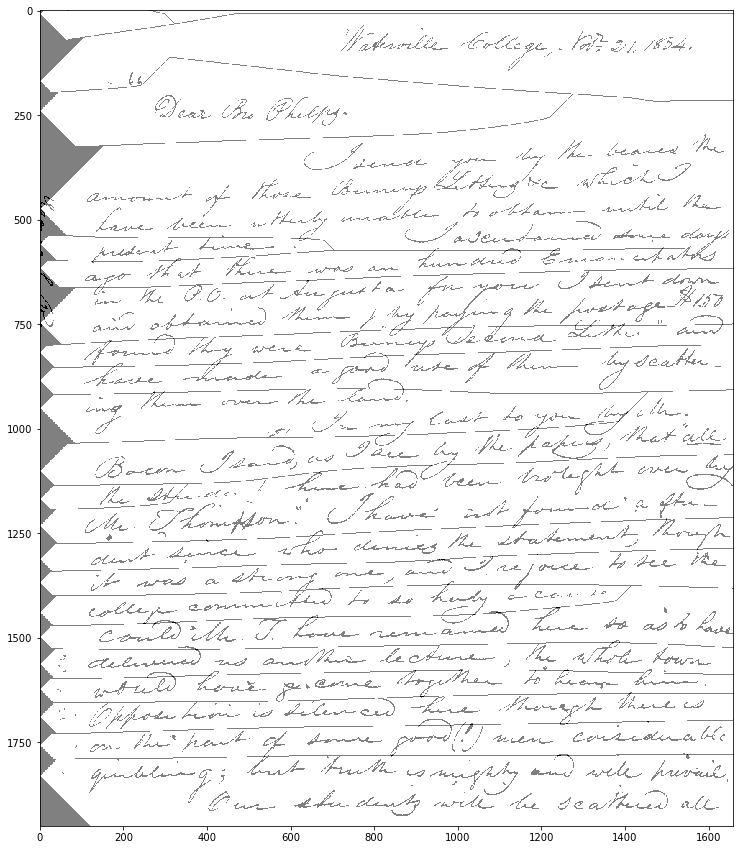

In [29]:
np.sum(np.ones(B.shape)) - np.sum(LA)
# plquick(LA, "gray")
plt.imshow(LA+(1-I), cmap="gray")
plt.show()

Using binarized other image

In [30]:
nk = B.shape[0]
Tr_list = []
for k in range(nk):
    tmp_list = []
    tmp_list.append(k)
    for n in range(1, B.shape[1]):
        tmp_list.append(Tr_np1(n, tmp_list[n-1], k, B3))
    Tr_list.append(tmp_list)

In [31]:
Tr_arr = np.array(Tr_list)

LA = np.ones(B.shape)
for y in range(B.shape[0]):
    for x in range(B.shape[1]):
        if y in Tr_arr[:, x]:
            LA[y, x] = 0

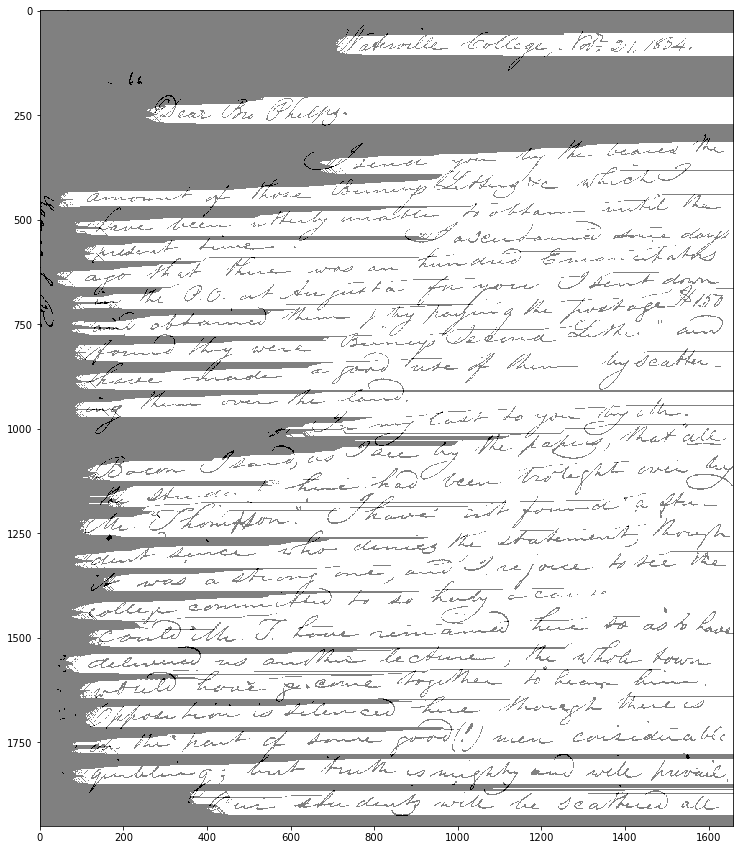

In [32]:
np.sum(np.ones(B.shape)) - np.sum(LA)
# plquick(LA, "gray")
plt.imshow(LA+(1-I), cmap="gray")
plt.show()